# Clustering 3k PBMCs following a Seurat Tutorial

This started out (July 2017) with a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) clustering tutorial ([link](http://satijalab.org/seurat/pbmc3k_tutorial.html)), which we gratefully acknowledge. In the meanwhile, we have added and removed several pieces.

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from scipy import sparse, io
from collections import Counter
import os.path
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import pickle
import os
import datetime
import hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import time
# import utils
import seurat_utils
import hyperopt_utils
plt.ion()
plt.show()
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()


scanpy==1.3.3 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
%load_ext autoreload
import importlib
importlib.reload(seurat_utils)
importlib.reload(hyperopt_utils)

scanpy==1.3.3 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


<module 'hyperopt_utils' from '/mnt/reds/projects/single-cell-sota/seurat/hyperopt_utils.py'>

## Generic method for running bayesian hyperparm optimisation for all datasets

In [3]:

def runSeurat(filename, space, max_evals = 2):
    # Define function to optimise
    def evaluateSeurat(args):
        args['cluster_n_neighbors'] = int(args['cluster_n_neighbors'])
        args['cluster_n_pcs'] = int(args['cluster_n_pcs'])

        if args['bpreprocess_min_genes'] == False:
            args['preprocess_min_genes'] = -1
        if args['bpreprocess_min_cells'] == False:
            args['preprocess_min_cells'] = -1
        if args['bpreprocess_teta_total_features'] == False:
            args['preprocess_teta_total_features'] = -1
        if args['bpreprocess_filter_min_mean'] == False:
            args['preprocess_filter_min_mean'] = -1
        if args['bpreprocess_filter_min_disp'] == False:
            args['preprocess_filter_min_disp'] = -1

        if args['preprocess_teta_total_features'] is not None:
            args['preprocess_teta_total_features'] = int(args['preprocess_teta_total_features'])
        try:
            resultDict = seurat_utils.run(args)
        except:
            return { 'status' : hyperopt.STATUS_FAIL}

        print(f'>> Result: {resultDict["randIndex"]}')
        ret = {
            'loss' : -resultDict['randIndex']
            ,'status' : STATUS_OK
            ,'eval_time' : time.time()        
        }
        return ret

    trials = hyperopt_utils.getTrials(filename ,restart = False )
    evals_per_epoch = 10
    for e in range(len(trials), max_evals, evals_per_epoch):
        best = fmin(evaluateSeurat
                    ,space
                    ,algo=tpe.suggest 
                    ,max_evals= e + evals_per_epoch
                    ,trials=trials)
        print('Index ', e)
        pickle.dump(trials, open(filename, 'wb'))
    return trials


# BrainCIDR

Run it once with all default parameters to get the parameter range

In [4]:
params = {}
params['load_inputDataset'] = 'brainCIDR'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = 8000
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = False

params['evaluate_plot_results'] = False
params['preprocess_plot_preprocessing'] = False
seurat_utils.run(params)

... reading from cache file ./cache/input-brainCIDR-matrix.h5ad
Loading dataset brainCIDR with 22085 genes and 420 cells
filtered out 2854 genes that are detected in less than 3 cells
Filtering Counter({False: 13027, True: 6204})
Keeping 6204 genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:06.59)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:01.87) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.21) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.01) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5341774376930473


{'cluster_n_neighbors': 10,
 'cluster_n_pcs': 40,
 'cluster_plot_pca': False,
 'evaluate_plot_results': False,
 'load_inputDataset': 'brainCIDR',
 'preprocess_filter_max_mean': 3,
 'preprocess_filter_min_disp': 0.5,
 'preprocess_filter_min_mean': 0.0125,
 'preprocess_min_cells': 3,
 'preprocess_min_genes': 200,
 'preprocess_normalize_per_cell': True,
 'preprocess_plot_preprocessing': False,
 'preprocess_regress_out': 'total_counts',
 'preprocess_scale': 10,
 'preprocess_teta_total_features': 8000,
 'randIndex': 0.5341774376930473}

### Hyperopt input

In [5]:

space = {
    'load_inputDataset' : 'brainCIDR'
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 5000, 15000, 1000)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

filename = 'brainCIDR_trials.pkl'


In [6]:
trials=hyperopt_utils.getTrials(filename ,restart = False )

Reload trials size :1990


In [ ]:
trials = runSeurat(filename, space, max_evals = 2000);

In [7]:
df = hyperopt_utils.getResultsAsDf(trials, space)
print(df.shape)
df.head()

(1990, 22)


,load_inputDataset,bpreprocess_min_genes,preprocess_min_genes,bpreprocess_min_cells,preprocess_min_cells,bpreprocess_teta_total_features,preprocess_teta_total_features,preprocess_normalize_per_cell,bpreprocess_filter_min_mean,preprocess_filter_min_mean,...,preprocess_filter_min_disp,preprocess_regress_out,preprocess_scale,cluster_n_neighbors,cluster_n_pcs,cluster_plot_pca,preprocess_plot_preprocessing,evaluate_plot_results,preprocess_verbosity,result
0,brainCIDR,False,430.0,False,3.0,False,11000.0,False,False,0.193999,...,0.225866,total_counts,20,12.0,40.0,False,False,False,0,NaN
1,brainCIDR,True,140.0,False,3.0,True,14000.0,True,True,0.032831,...,0.328177,total_counts,20,5.0,30.0,False,False,False,0,-0.431302
2,brainCIDR,False,420.0,True,8.0,False,14000.0,False,False,0.100963,...,0.087037,total_counts,15,19.0,22.0,False,False,False,0,-0.774876
3,brainCIDR,False,240.0,True,8.0,True,14000.0,False,False,0.035382,...,0.754317,total_counts,20,17.0,28.0,False,False,False,0,-0.551759
4,brainCIDR,False,250.0,False,15.0,False,13000.0,False,True,0.197635,...,0.737586,none,15,5.0,22.0,False,False,False,0,-0.431472


Best result: 

In [8]:
df.sort_values(by='result').head()

,load_inputDataset,bpreprocess_min_genes,preprocess_min_genes,bpreprocess_min_cells,preprocess_min_cells,bpreprocess_teta_total_features,preprocess_teta_total_features,preprocess_normalize_per_cell,bpreprocess_filter_min_mean,preprocess_filter_min_mean,...,preprocess_filter_min_disp,preprocess_regress_out,preprocess_scale,cluster_n_neighbors,cluster_n_pcs,cluster_plot_pca,preprocess_plot_preprocessing,evaluate_plot_results,preprocess_verbosity,result
1297,brainCIDR,True,400.0,False,4.0,False,14000.0,True,False,0.164068,...,0.034802,none,-1,16.0,48.0,False,False,False,0,-0.931892
501,brainCIDR,True,170.0,False,16.0,False,7000.0,True,False,0.028897,...,0.213911,none,-1,16.0,48.0,False,False,False,0,-0.931892
843,brainCIDR,True,250.0,False,17.0,False,6000.0,True,False,0.074194,...,0.090919,none,-1,16.0,48.0,False,False,False,0,-0.931892
1462,brainCIDR,True,330.0,False,7.0,False,11000.0,True,False,0.077990,...,0.146146,none,-1,16.0,48.0,False,False,False,0,-0.931892
1007,brainCIDR,True,280.0,False,20.0,False,10000.0,True,False,0.080347,...,0.055078,none,-1,16.0,48.0,False,False,False,0,-0.931892


In [9]:
df.to_pickle('brainCIDR.pkl')

# PancreaticIsletCIDR

Run it once with all default parameters to get the parameter range

... writing an h5ad cache file to speedup reading next time
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 62604 genes that are detected in less than 3 cells


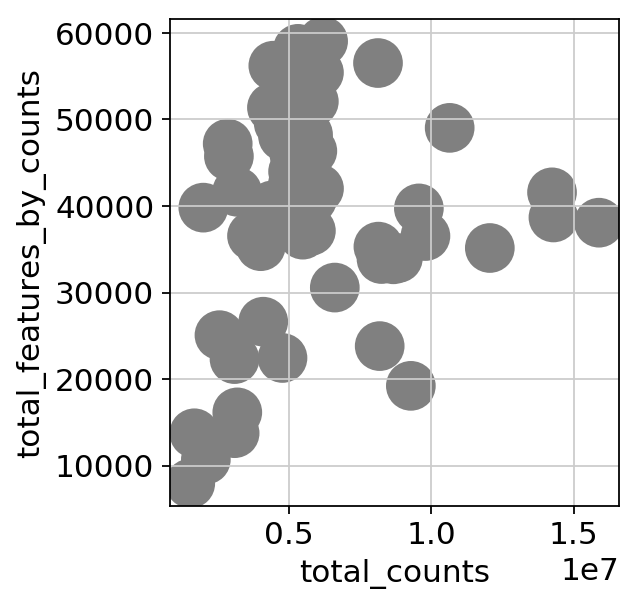

Filtering Counter({False: 83339, True: 34310})


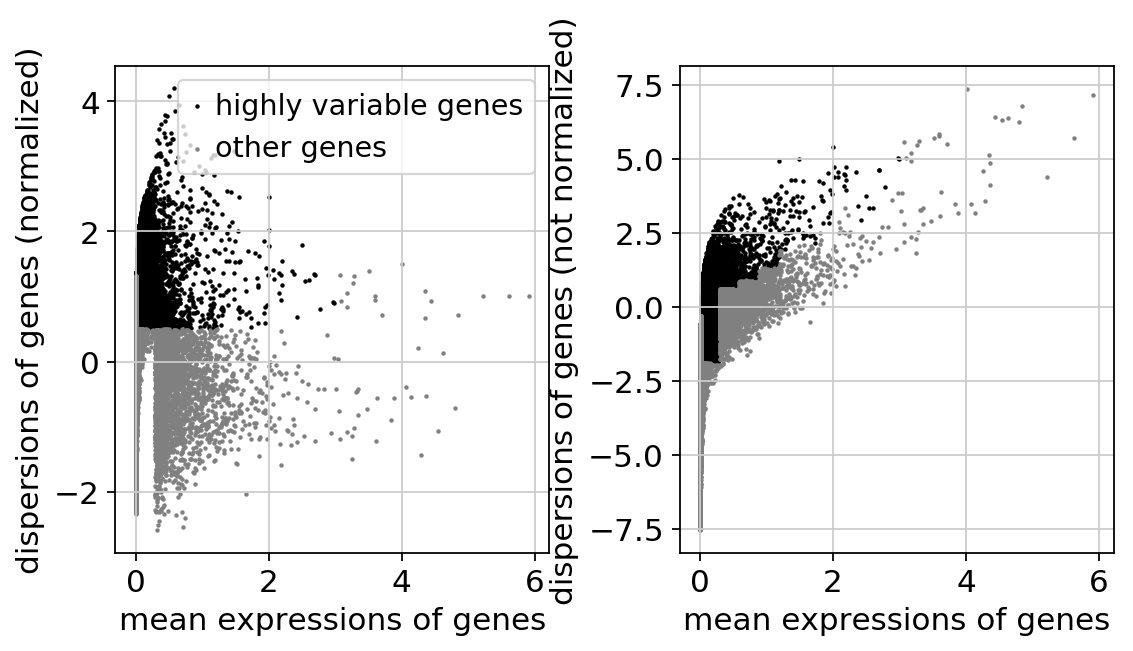

Keeping 34310 genes
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:32.85)


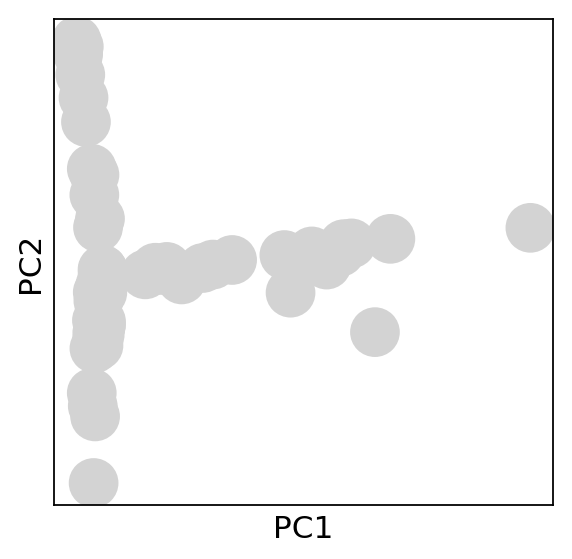

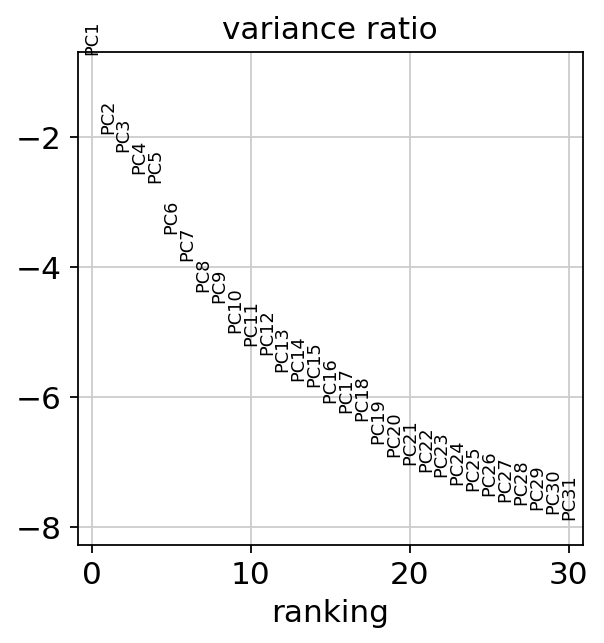

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


ValueError: RGBA values should be within 0-1 range

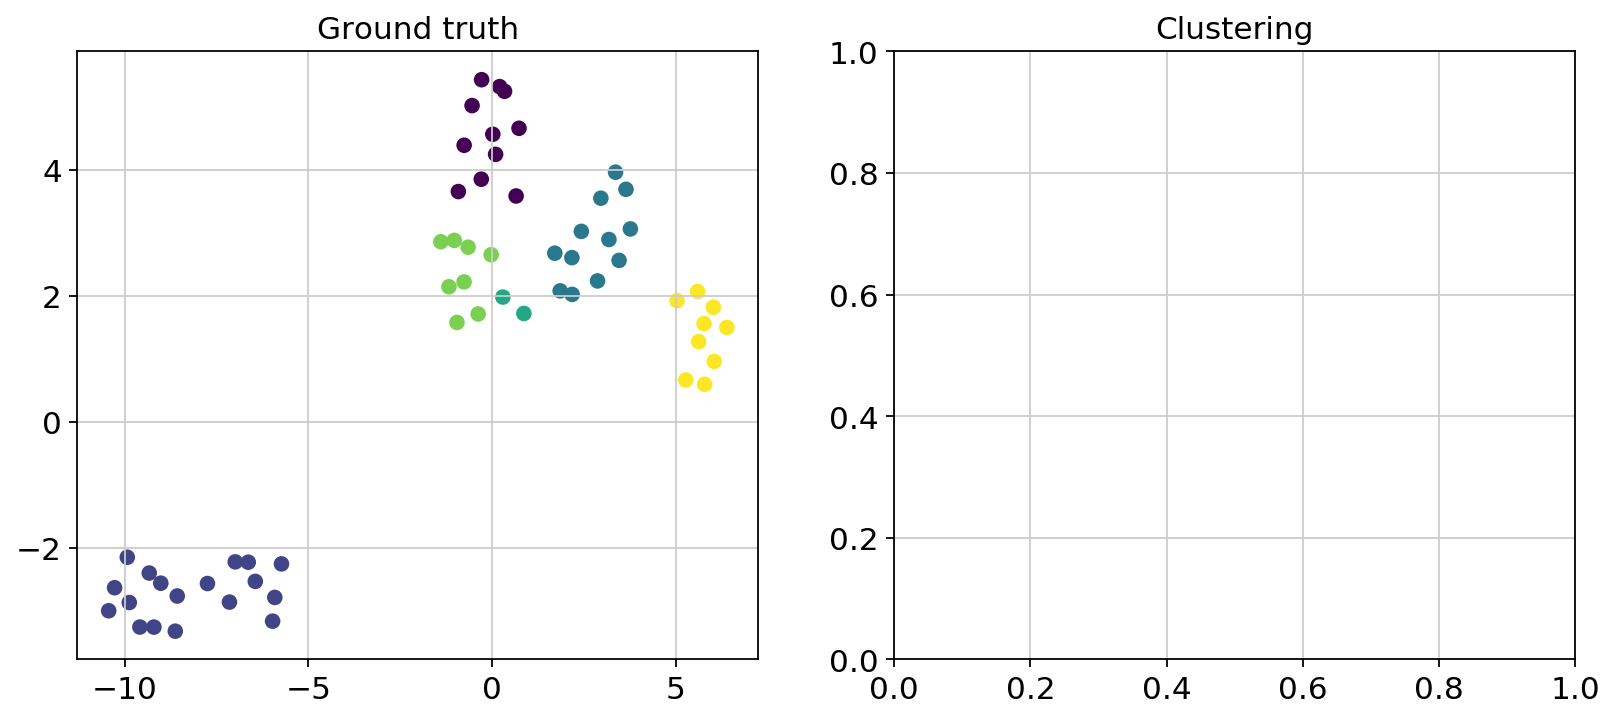

In [10]:
params = {}
params['load_inputDataset'] = 'pancreaticIsletCIDR'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']='total_counts'
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = True

params['evaluate_plot_results'] = True
seurat_utils.run(params);

### Hyperopt input

In [4]:

space = {
    'load_inputDataset' : 'pancreaticIsletCIDR'
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 45000, 60000, 2000)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

filename = 'pancreaticIsletCIDR_trials.pkl'  

In [5]:
# trials=hyperopt_utils.getTrials(filename ,restart = False )

In [6]:

trials = runSeurat(filename, space, max_evals = 2000);

Reload trials size :1840
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.29)
computing neighbors
    using 'X_pca' with n_pcs = 37
    finished (0:00:01.81) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.70) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7916313043097359
>> Result: 0.7916313043097359
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 76052 genes that are detected in less than 5.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 47
    finished (0:00:00.00) --> added to `.uns['ne

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1000: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:788: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 76052 genes that are detected in less than 5.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 26
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 107488 genes that are detected in less than 12.0 cells
computing neighbors
    using 'X_p

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 86874 genes that are detected in less than 7.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 29
    finished (0:00:00.02) --> added to `.uns['ne

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 48
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.8178298948878161
>> Result: 0.8178298948878161
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 32
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connect

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:864: RuntimeWarning: divide by zero encountered in true_divide
  D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0],
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1556: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10.59)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 62604 genes that are detected in le

computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.01) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7801053433524618
>> Result: 0.7801053433524618
Index  1880
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.67)
computing neighbors
    using 'X_pca' with n_pcs = 35
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities',

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:1000: RuntimeWarning: invalid value encountered in true_divide
  X /= scale
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:788: RuntimeWarning: invalid value encountered in greater
  if max_value is not None: X[X > max_value] = max_value


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 76052 genes that are detected in less than 5.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.34)
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 g

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 28
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.8178298948878161
>> Result: 0.8178298948878161
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 62604 genes that are detected in less than 3.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:06.17)
computing neighbors
    using 'X_pca' with n_pcs = 39
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7881156938036963
>> Result: 0.7881156938036963
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 g

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08.53)
computing neighbors
    using 'X_pca' with n_pcs = 38
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7881156938036963
>> Result: 0.7881156938036963
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08.97)
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
Index  1910
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca

    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.8272327964860908
>> Result: 0.8272327964860908
Index  1920
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 69845 genes that are detected in less than 4.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.37)
computing neighbors
    using 'X_pca' with n_pcs = 33
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'l

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 43
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7916313043097359
>> Result: 0.7916313043097359
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 103850 genes that are detected in less than 11.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 23
    finished (0:00:00.00) --> added to `.uns['

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:11.03)
computing neighbors
    using 'X_pca' with n_pcs = 24
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 81836 genes that are detected in less than 6.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.07)
com

computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 100059 genes that are detected in less than 10.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 25
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
computing neighbors
    using 'X_pca' with n_pcs = 36
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08.52)
computing neighbors
    using 'X_pca' with n_pcs

... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 53630 genes that are detected in less than 2.0 cells
computing neighbors
    using 'X_pca' with n_pcs = 27
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    fini

    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 81836 genes that are detected in less than 6.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10.64)
computing neighbors
    using 'X_pca' with n_pcs = 47
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "l

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:681: RuntimeWarning: invalid value encountered in long_scalars
  n_chunks = np.ceil(adata.X.shape[1] / len_chunk).astype(int)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08.56)
computing neighbors
    using 'X_pca' with n_pcs = 48
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
regressing out ['total_counts']
    sparse input

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:681: RuntimeWarning: invalid value encountered in long_scalars
  n_chunks = np.ceil(adata.X.shape[1] / len_chunk).astype(int)


... reading from cache file ./cache/input-pancreaticIsletCIDR-matrix.h5ad
Loading dataset pancreaticIsletCIDR with 180253 genes and 60 cells
filtered out 122897 genes that are detected in less than 17.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:05.88)
computing neighbors
    using 'X_pca' with n_pcs = 44
    finished (0:00:00.00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.9713270358108314
>> Result: 0.9713270358108314
Index  1990


In [7]:
df = hyperopt_utils.getResultsAsDf(trials, space)
df.head()

,load_inputDataset,bpreprocess_min_genes,preprocess_min_genes,bpreprocess_min_cells,preprocess_min_cells,bpreprocess_teta_total_features,preprocess_teta_total_features,preprocess_normalize_per_cell,bpreprocess_filter_min_mean,preprocess_filter_min_mean,...,preprocess_filter_min_disp,preprocess_regress_out,preprocess_scale,cluster_n_neighbors,cluster_n_pcs,cluster_plot_pca,preprocess_plot_preprocessing,evaluate_plot_results,preprocess_verbosity,result
0,pancreaticIsletCIDR,False,170.0,True,11.0,False,56000.0,True,True,0.182841,...,0.195063,total_counts,20,15.0,40.0,False,False,False,0,-0.725379
1,pancreaticIsletCIDR,False,220.0,False,7.0,False,52000.0,True,True,0.007618,...,0.812531,total_counts,5,8.0,29.0,False,False,False,0,-0.817830
2,pancreaticIsletCIDR,True,290.0,False,4.0,True,56000.0,True,False,0.080728,...,0.344678,none,5,20.0,37.0,False,False,False,0,-0.753535
3,pancreaticIsletCIDR,False,480.0,False,6.0,True,58000.0,True,True,0.129369,...,0.130010,total_counts,10,7.0,30.0,False,False,False,0,-0.769705
4,pancreaticIsletCIDR,False,180.0,False,2.0,False,58000.0,False,False,0.149208,...,0.625545,none,-1,11.0,24.0,False,False,False,0,-0.239425


Best result: 

In [8]:
df['result'].min()

-0.9713270358108314

In [9]:
df.to_pickle('pancreaticIsletCIDR.pkl')

# Deng

Run it once with all default parameters to get the parameter range

In [ ]:
params = {}
params['load_inputDataset'] = 'deng'
params['preprocess_min_genes'] = 200
params['preprocess_min_cells'] = 3
# Define on the dataset
params['preprocess_teta_total_features'] = -1
params['preprocess_normalize_per_cell'] = True
params['preprocess_filter_min_mean'] = 0.0125
params['preprocess_filter_max_mean']=3
params['preprocess_filter_min_disp']=0.5
params['preprocess_regress_out']=None
params['preprocess_scale']=10

params['cluster_n_neighbors'] = 10
params['cluster_n_pcs'] = 40
params['cluster_plot_pca'] = False

params['evaluate_plot_results'] = True
seurat_utils.run(params)

### Hyperopt input

In [4]:

space = {
    'load_inputDataset' : 'deng'
    ,'bpreprocess_min_genes' : hp.choice('bpreprocess_min_genes', [True,False])
    ,'preprocess_min_genes' : hp.quniform('preprocess_min_genes', 100, 500, 10)
    
    ,'bpreprocess_min_cells' : hp.choice('bpreprocess_min_cells', [True,False])
    ,'preprocess_min_cells' : hp.quniform('preprocess_min_cells', 1, 20, 1)
    
    ,'bpreprocess_teta_total_features' : hp.choice('bpreprocess_teta_total_features', [True,False])
    ,'preprocess_teta_total_features' : hp.quniform('preprocess_teta_total_features', 10000, 15000, 500)

    ,'preprocess_normalize_per_cell' : hp.choice('l_preprocess_normalize_per_cell', 
                                                 [True, False])

    ,'bpreprocess_filter_min_mean' : hp.choice('bpreprocess_filter_min_mean', [True,False])
    ,'preprocess_filter_min_mean' : hp.uniform('preprocess_filter_min_mean', 0, 0.2) # 0.0125
    ,'preprocess_filter_max_mean' : hp.uniform('preprocess_filter_max_mean', 0, 5)
    
    ,'bpreprocess_filter_min_disp' : hp.choice('bpreprocess_filter_min_disp', [True,False])
    ,'preprocess_filter_min_disp' : hp.uniform('preprocess_filter_min_disp', 0, 1)# 0.5
    
    ,'preprocess_regress_out' : hp.choice('l_preprocess_regress_out', ['none', 'total_counts'])
    ,'preprocess_scale' : hp.choice('l_preprocess_scale', [-1, 5, 10, 15, 20]) #10
    ,'cluster_n_neighbors' : hp.quniform('cluster_n_neighbors', 1, 20,1) #10
    ,'cluster_n_pcs' : hp.quniform('cluster_n_pcs', 20, 50, 1)  # 40
    ,'cluster_plot_pca' : False
    ,'preprocess_plot_preprocessing' : False
    ,'evaluate_plot_results': False
    ,'preprocess_verbosity' : 0
}

filename = 'deng_trials.pkl'  

In [5]:
# trials=hyperopt_utils.getTrials(filename ,restart = False )


In [6]:

trials = runSeurat(filename, space, max_evals = 5000);

Reload trials size :4690
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.08)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:01.81) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.07) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.94)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.44) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.07)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7032466683176172
>> Result: 0.7032466683176172
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected i

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.00)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6587301048687101
>> Result: 0.6587301048687101
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.06)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6403882876020348
>> Result: 0.6403882876020348
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.76)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5691388692740819
>> Result: 0.5691388692740819
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.70)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7032466683176172
>> Result: 0.7032466683176172
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.74)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5691388692740819
>> Result: 0.5691388692740819
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.96)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6112133378966988
>> Result: 0.6112133378966988
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.84)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7032466683176172
>> Result: 0.7032466683176172
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.75)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6574197810941769
>> Result: 0.6574197810941769
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.08)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6781636820945558
>> Result: 0.6781636820945558
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.21)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.03) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6067459875775687
>> Result: 0.6067459875775687
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.41)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


Index  4790
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.07)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that ar

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.32)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


Index  4810
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.22)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7112920910379571
>> Result: 0.7112920910379571
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that ar

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.32)
computing neighbors
    using 'X_pca' with n_pcs = 22
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6071858923952449
>> Result: 0.6071858923952449
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.20)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.41) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
Index  4830
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that ar

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.97)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6781636820945558
>> Result: 0.6781636820945558
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.15)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7112920910379571
>> Result: 0.7112920910379571
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.06)
computing neighbors
    using 'X_pca' with n_pcs = 22
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.39657184077105273
>> Result: 0.39657184077105273
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detecte

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.54)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6067459875775687
>> Result: 0.6067459875775687
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use


/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.39)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.3777554693791718
>> Result: 0.3777554693791718
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5470 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.35)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.69103349729394
>> Result: 0.69103349729394
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in l

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.15)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6393465857604397
>> Result: 0.6393465857604397
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.11)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.09)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.25)
computing neighbors
    using 'X_pca' with n_pcs = 41
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.29645193654209995
>> Result: 0.29645193654209995
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.29)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5691388692740819
>> Result: 0.5691388692740819
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.98)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6112133378966988
>> Result: 0.6112133378966988
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.30)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.43) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7032466683176172
>> Result: 0.7032466683176172
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5470 genes that are detected i

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.86)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.38) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6831508847337716
>> Result: 0.6831508847337716
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5470 genes that are detected in less than 11.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.88)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5672808058741922
>> Result: 0.5672808058741922
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.89)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6587301048687101
>> Result: 0.6587301048687101
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected 

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected in less than 8.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.32)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6067459875775687
>> Result: 0.6067459875775687
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:17.94)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.5632208165077702
>> Result: 0.5632208165077702
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected i

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected in less than 10.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.60)
computing neighbors
    using 'X_pca' with n_pcs = 23
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.40) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6129335885699934
>> Result: 0.6129335885699934
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4687 genes that are detected

... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.09)
computing neighbors
    using 'X_pca' with n_pcs = 21
    finished (0:00:00.06) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.37) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.6112133378966988
>> Result: 0.6112133378966988
... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 5221 genes that are detected 

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:176: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(resid_dev * freq_weights * var_weights / scale)


... reading from cache file ./cache/input-deng-matrix.h5ad
Loading dataset deng with 22431 genes and 268 cells
filtered out 4965 genes that are detected in less than 9.0 cells
regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:18.42)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.42) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Rand_index 0.7118270420509001
>> Result: 0.7118270420509001
Index  4990


In [7]:
df = hyperopt_utils.getResultsAsDf(trials, space)
df.head()

,load_inputDataset,bpreprocess_min_genes,preprocess_min_genes,bpreprocess_min_cells,preprocess_min_cells,bpreprocess_teta_total_features,preprocess_teta_total_features,preprocess_normalize_per_cell,bpreprocess_filter_min_mean,preprocess_filter_min_mean,...,preprocess_filter_min_disp,preprocess_regress_out,preprocess_scale,cluster_n_neighbors,cluster_n_pcs,cluster_plot_pca,preprocess_plot_preprocessing,evaluate_plot_results,preprocess_verbosity,result
0,deng,True,450.0,True,6.0,False,10500.0,True,True,0.059320,...,0.927361,none,15,10.0,32.0,False,False,False,0,-0.468147
1,deng,False,380.0,False,3.0,False,14500.0,False,True,0.089560,...,0.462228,total_counts,15,19.0,36.0,False,False,False,0,NaN
2,deng,True,460.0,False,16.0,True,10500.0,False,True,0.066919,...,0.085857,total_counts,10,7.0,38.0,False,False,False,0,-0.348496
3,deng,False,470.0,False,8.0,False,12000.0,True,False,0.152388,...,0.437641,total_counts,15,11.0,36.0,False,False,False,0,NaN
4,deng,False,310.0,True,12.0,False,13500.0,True,False,0.149257,...,0.844344,none,-1,7.0,27.0,False,False,False,0,-0.617424


Best result: 

In [8]:
df['result'].min()

-0.7118270420509001

In [9]:
df.to_pickle('deng.pkl')

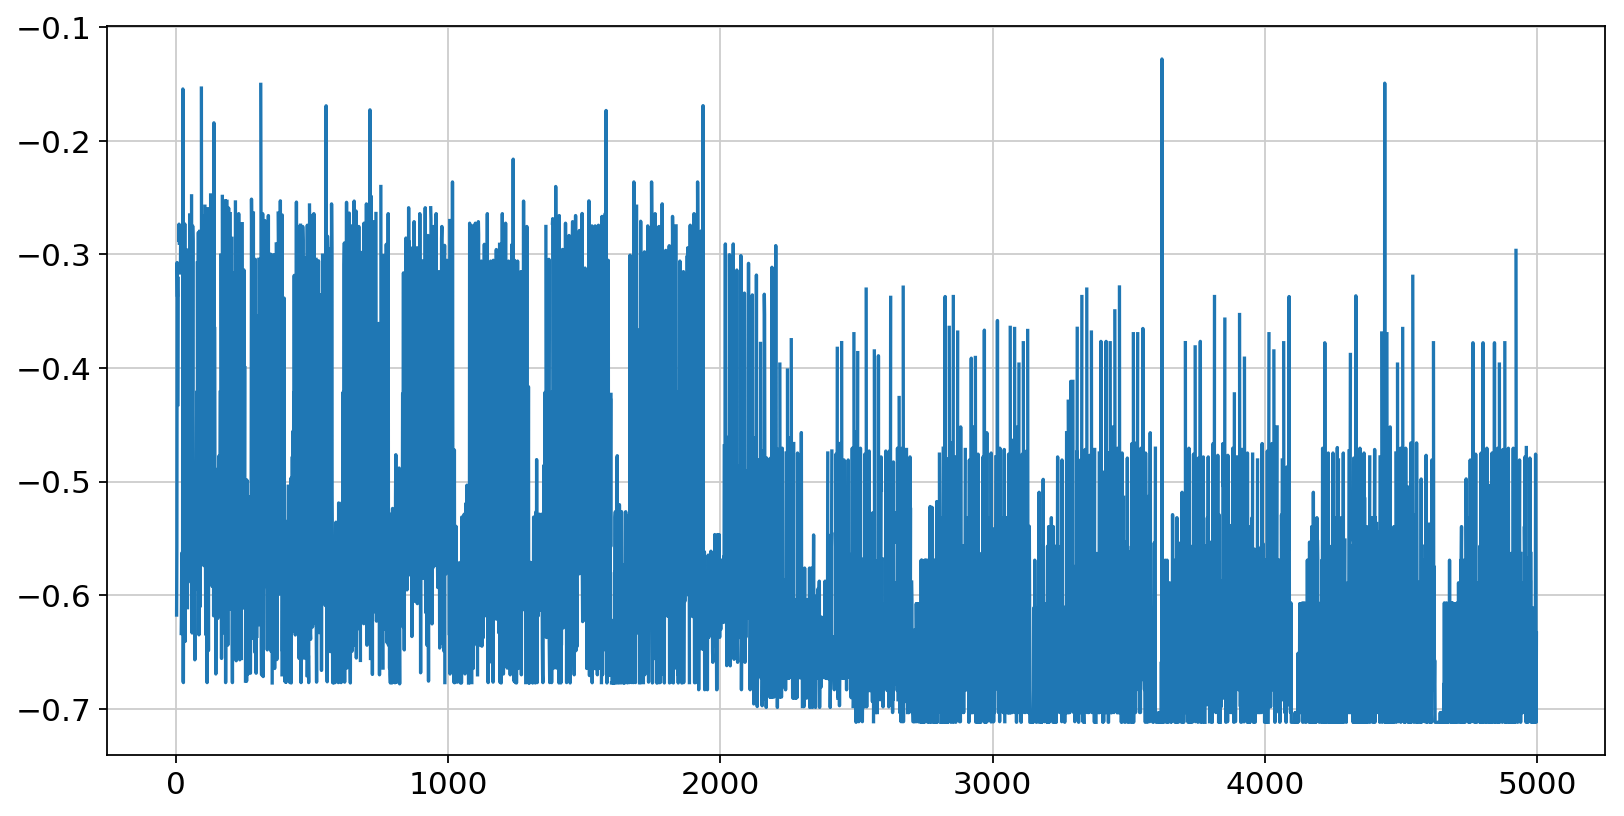

In [10]:
plt.figure(figsize=(12,6))
df.result.plot()
# plt.ylim(-1, -0.8)
# plt.xlim(0,50)

In [11]:
list(df.columns)

['load_inputDataset',
 'bpreprocess_min_genes',
 'preprocess_min_genes',
 'bpreprocess_min_cells',
 'preprocess_min_cells',
 'bpreprocess_teta_total_features',
 'preprocess_teta_total_features',
 'preprocess_normalize_per_cell',
 'bpreprocess_filter_min_mean',
 'preprocess_filter_min_mean',
 'preprocess_filter_max_mean',
 'bpreprocess_filter_min_disp',
 'preprocess_filter_min_disp',
 'preprocess_regress_out',
 'preprocess_scale',
 'cluster_n_neighbors',
 'cluster_n_pcs',
 'cluster_plot_pca',
 'preprocess_plot_preprocessing',
 'evaluate_plot_results',
 'preprocess_verbosity',
 'result']

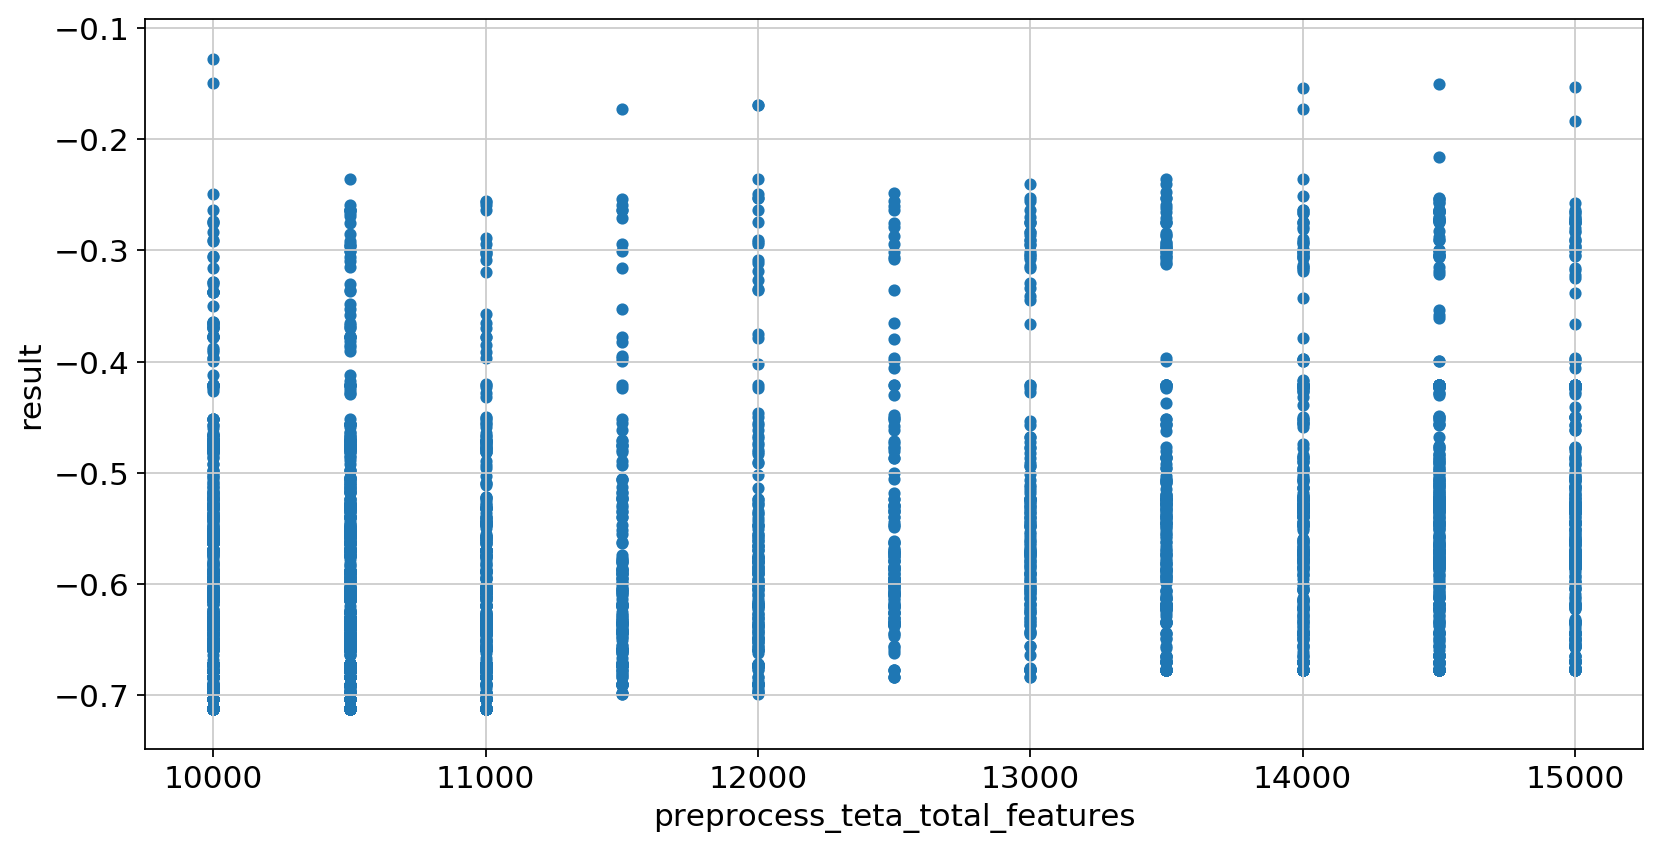

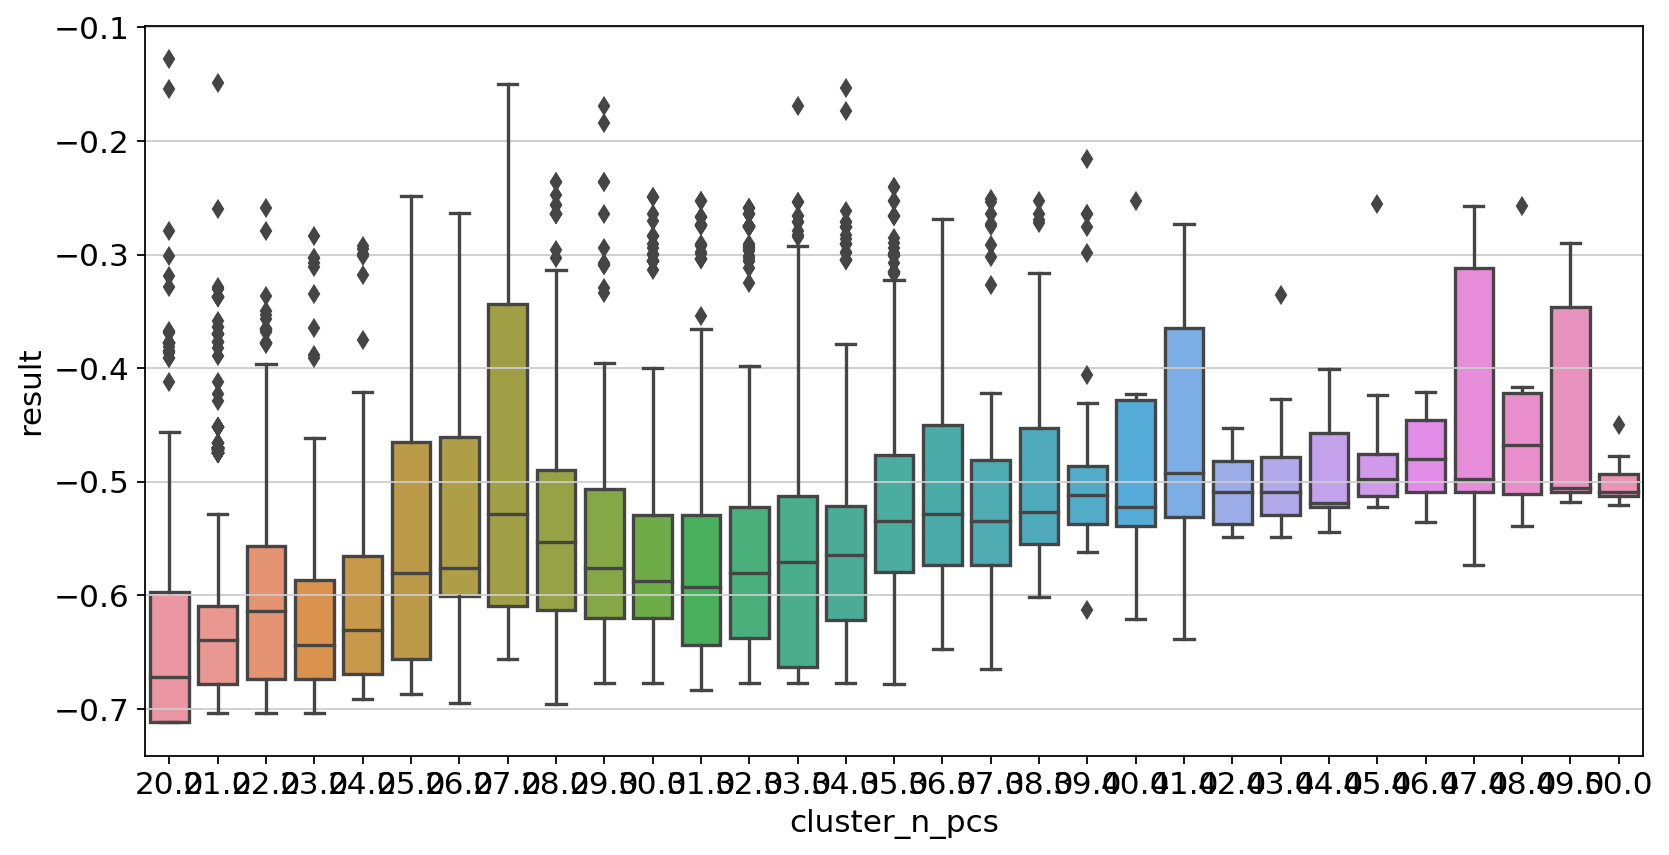

In [34]:
import seaborn as sns
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
df[['preprocess_teta_total_features','result']].plot(kind='scatter', y='result', x='preprocess_teta_total_features', ax=ax)


plt.figure(figsize=(12,6))
sns.boxplot(df.cluster_n_pcs,df.result)

# plt.figure(figsize=(12,6))
# sns.lmplot(df.preprocess_teta_total_features,df.result)